

## Gesture Classification with SEN-ResNet (Custom Resnet 26)

Please change the CIFAR-10 data to your local images resized to 32*32*3

In [0]:
#Headers Definition
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import random
import time
import os

###Loading and splitting the data (Train/ Test/ Validate):

In [2]:
#Transformations
transform = transforms.Compose([     transforms.RandomCrop(32, padding=4), 
                                       transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                     ]) #normalize each channel =>image = (image - mean) / std

transform_test = transforms.Compose([ transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                     ]) #normalize each channel =>image = (image - mean) / std

                  


#loading the dataset and preprocessing it
# Change this to your local dataset and resize your data to 32*32*3 .........
CIFAR_train= torchvision.datasets.CIFAR10("./data",train=True, download=True, transform=transform) #Training Data
CIFAR_test= torchvision.datasets.CIFAR10("./data",train=False, download=True, transform=transform_test) #Testing Data

#Create Validation Set (Stratify from SKLEARN can be used but CIFAR is very balanced so no need)
indices = list(range(len(CIFAR_train)))
seed=30
np.random.seed(seed)
np.random.shuffle(indices)

split = int(np.floor(0.9 * len(CIFAR_train)))
tr_idx, val_idx = indices[:split], indices[split:]

tr_sampler = SubsetRandomSampler(tr_idx)
val_sampler = SubsetRandomSampler(val_idx)
 

#How are we gonna iterate over the data?
train_loader= torch.utils.data.DataLoader(CIFAR_train,batch_size=128,sampler=tr_sampler,num_workers=2) #batch_size : process the data in batches and make a better generalization
valid_loader= torch.utils.data.DataLoader(CIFAR_train,batch_size=128,sampler=val_sampler,num_workers=2)
test_loader= torch.utils.data.DataLoader(CIFAR_test,batch_size=128,shuffle=False,num_workers=2)  #shuffling the data makes a better generalization

# data labels
labels = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#each data has 4 images

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


###This cell is only for checking the visuals for one picture (You can skip this): 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 32, 32])
plane


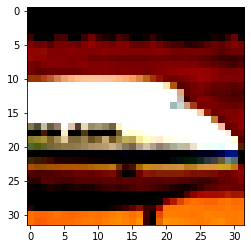

In [3]:
import matplotlib.pyplot as plt
import numpy as np

#every type you run this it is shuffled
for data in train_loader:
  print(data[0].shape)  # batch_size, # channels, #height, #width
  break

#Every data is a list of: 1.#(batch_size)images   2.#(batch_size)labels

# show images
plt.imshow(np.transpose(data[0][0], (1, 2, 0))) #replace 0 with 1 axis and 1 with 2 and 2 with 0  -> output: height,width ,channel
plt.show
print(labels[data[1][0]])

### Sqeueeze and Excitation Block:

In [0]:
class SEBlock(nn.Module):
  #Initialize your BasicBlock strucutre
  def __init__(self, channel, reduction=4):
    super().__init__()
    self.avg_pool = nn.AdaptiveAvgPool2d(1) #Squeezing

    #excitation
    self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

  def forward(self, x):
    #x is the output of the original residual block -> after finding weights scale and multiply
    b, c, _, _ = x.size()
    y = self.avg_pool(x).view(b, c)
    y = self.fc(y).view(b, c, 1, 1) #rescale to image
    return x * y.expand_as(x) #y is the weight of each feature map

### Basic Block Definition (BottleNeck Block is not needed in ResNet-18):

In [0]:
class BasicBlock(nn.Module):
  #Initialize your BasicBlock strucutre
  def __init__(self,in_channels,out_channels,stride=1):
    super().__init__()

    # Remember:
        #Conv2d Parameters: input channels,output channels, size_kernel
        #BatchNorm Goals: Normalize the outputs, parameters:(#output_channels/ node)
    
    #First Convolution: changes the dimensions of image according to the given parameters
    self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1) #change channels   #reduce size to half if stride is set to two
    self.bn1 = nn.BatchNorm2d(out_channels)

    #Second Convolution: doesn't change the dimensions at all (ignore it in calculation)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)

    #SE Block
    self.SE_Block = SEBlock(out_channels)

    #This changes the input size to match the output size: #change channels   #reduce size to half if stride is set to two
    self.input_changer = nn.Sequential()
    if stride != 1  or in_channels != out_channels:
      self.input_changer = nn.Sequential( nn.Conv2d(in_channels, out_channels, 1, stride=stride),nn.BatchNorm2d(out_channels))

  def forward(self, x):
    #x is original data
    output=x
    #Pass through the first convolution
    output= F.relu(self.bn1(self.conv1(output)))  #conv -> normalize -> activate/threshold
    #Pass through the first convolution
    output= F.relu(self.bn2(self.conv2(output)))
    #Multiply by SE_Block Weights
    output=self.SE_Block(output)
    #Add the input
    output+=self.input_changer(x)
    return F.relu(output)

### ResNet-26 Neural Network Definition:

In [0]:
class ResNet_18(nn.Module):
  #initialize your network strucutre
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1) #3,32,32 -> 64,32,32
    self.bn1 = nn.BatchNorm2d(64)
    
    
    #First Block: Change channels   #Other Blocks: Don't change anything  #Last Block: Change dimesnsions using stride 2
    self.conv2=nn.Sequential(BasicBlock(64,64,1),BasicBlock(64,64,1),BasicBlock(64,64,1)) #64,32,32 -> 64,32,32 ->64,32,32

    self.conv3=nn.Sequential(BasicBlock(64,128,1),BasicBlock(128,128,1),BasicBlock(128,128,2)) #64,32,32 ->128,32,32 ->128,16,16
    
    self.conv4=nn.Sequential(BasicBlock(128,256,1),BasicBlock(256,256,1),BasicBlock(256,256,2)) #128,16,16 ->256,16,16 ->256,8,8
    
    self.conv5=nn.Sequential(BasicBlock(256,512,1),BasicBlock(512,512,1),BasicBlock(512,512,2)) #256,8,8 ->512,8,8 ->512,4,4

    self.pool = nn.AvgPool2d(2, 2) #512,4,4 -> 512,2,2

    self.fc=nn.Linear(512*2*2, 10)
  
  def forward(self, x):
    x=F.relu(self.bn1(self.conv1(x))) #conv -> normalize -> activate/threshold

    #BasicBlocks
    x=self.conv2(x)
    x=self.conv3(x)
    x=self.conv4(x)
    x=self.conv5(x)

    x=self.pool(x)

    #flatten
    x=x.view(-1, 512*2*2)
    x=self.fc(x)

    return x


###Driver Code:

In [7]:
# Select GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("This model is running on" , torch.cuda.get_device_name())

#Model
net=ResNet_18().to(device)

#Get adjustable parameters(weights) and optimize them 
optimizer=optim.Adam(net.parameters(),lr=0.001,weight_decay=0.0001) #weight decay is multiplied to weight to prevent them from growing too large

#Error Function
criterion = nn.CrossEntropyLoss() 

# Learning rate scheduler: adjusts learning rate as the epoch increases
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1) #Decays the learning rate by multiplyin by gamma every step_size epochs

#How many times we pass our full data (the same data)
total_epoch=50 

cuda:0
This model is running on Tesla P4


###Training and Validation:

In [8]:
best_valid_acc=0

for cur_epoch in range(total_epoch):
  train_correct=0
  train_total=0
  train_loss=0 #loss per epoch

  valid_correct=0
  valid_total=0
  valid_loss=0 #loss per epoch
  
  net.train() #put the model in training mode
  for data in train_loader:

    #every data consits of (batch_size) images
    X,y=data[0].to(device), data[1].to(device) #picture(X batch_size), label(X batch_size) -> #batch size comes first #note that the label here is a number which is index in labels list
    
    net.zero_grad()  
    output = net(X)  
    loss = criterion(output, y) #calculate the error/ loss for the that batch (data)

    loss.backward()  #computes dloss/dw for every parameter w  (loss for every parameter)
    optimizer.step() #update weights
    train_loss+=loss.item()

    #calculate how many right do you have in every training data until the end of all training datas
    #output is Batch_size*10 tensor
    for k, i in enumerate(output): # the output is batch_size* 10 tensor   # k is the index of the data # i the data itself
        if torch.argmax(i) == y[k]: # in every row find the highest prediction index and compare it to y[k]
                train_correct += 1
        train_total += 1

  exp_lr_scheduler.step() #learning rate adjustment
  
  net.eval() #put the model in evaluation mode
  #validate for each epoch
  with torch.no_grad(): # no gradient
    for data in valid_loader:
      X, y = data[0].to(device), data[1].to(device) # store the images in X and labels in y
      output = net(X) 
      loss = criterion(output, y)

      valid_loss += loss.item()

      for k, i in enumerate(output): # the output is batch_size* 10 ARRAY
          if torch.argmax(i) == y[k]: # in every row find the highest prediction and comprae its index
              valid_correct += 1
          valid_total += 1
  
  #if the model is better than the previous best store it
  if((valid_correct/valid_total)>best_valid_acc):
    best_valid_acc= (valid_correct/valid_total)
    torch.save(net.state_dict(), "./save_best.pth") #save early stopping point

  if((cur_epoch+1)%(total_epoch*0.1)==0):
    print(' Epoch {}/{}: Training Accuracy {} |  Training Loss {} || Validation Accuracy {} |  Validation Loss {}'.format(cur_epoch+1, total_epoch, train_correct/train_total,train_loss/len(train_loader),valid_correct/valid_total,valid_loss/len(valid_loader))) #accuray for each epoch
    print(' Best validation so far {}'.format(best_valid_acc))
    print('-------------------------------------------------------------------------------------------------------------------------------')

 Epoch 5/50: Training Accuracy 0.7813111111111111 |  Training Loss 0.6260925026779826 || Validation Accuracy 0.7764 |  Validation Loss 0.6579059712588787
 Best validation so far 0.7764
-------------------------------------------------------------------------------------------------------------------------------
 Epoch 10/50: Training Accuracy 0.8597777777777778 |  Training Loss 0.41012049453671684 || Validation Accuracy 0.8328 |  Validation Loss 0.5088349133729935
 Best validation so far 0.8328
-------------------------------------------------------------------------------------------------------------------------------
 Epoch 15/50: Training Accuracy 0.8920666666666667 |  Training Loss 0.31536976887251844 || Validation Accuracy 0.8326 |  Validation Loss 0.5067954331636428
 Best validation so far 0.859
-------------------------------------------------------------------------------------------------------------------------------
 Epoch 20/50: Training Accuracy 0.9142222222222223 |  Trai

###Testing:

In [9]:
#load the best validation accuracy model so far
load_model = ResNet_18().to(device)
load_model.load_state_dict(torch.load("./save_best.pth")) 

load_model.eval()

correct =0
total=0
with torch.no_grad(): # no gradient
  for data in test_loader:
      X, y = data[0].to(device), data[1].to(device) # store the images in X and labels in y
      output = load_model(X) #send the 4 images
      #print(output)
      for k, i in enumerate(output): # the output is 4* 10 ARRAY
          if torch.argmax(i) == y[k]: # in every row find the highest prediction and comprae its index
              correct += 1
          total += 1

print("Test Accuracy: ", correct/total)

Test Accuracy:  0.931
